# Modeling without Text Features

In this notebook we train and evaluate a basic deep learning model for the Wells Fargo stock price time series. This first model will only include the pricing time series data of the 4 bank stocks, Wells Fargo, JPMorgan Chase, Bank of America, and Citigroup, as the input features to the model. The notebook can be broken up into 3 different parts: Model Architecture, Unit Testing Model, and Model Evaluation. In the Model Architecture portion we will explore the chosen architecture for the model. Afterwards we will run a few tests on the chosen model architecture to assure us that the code is free of potential bugs in the Unit Testing Model portion. Finally, in the Model Evaluation section, we will train and evaluate the chosen model architecture for a few different sets of hyperparameters and record the results.

## Model Architecture:

The main goal of this project is to construct a machine learning model that can predict stock prices accurately. We have no constraints on this project other than the ability for the model to predict prices well, which suggests that the most important measure of success for our model would be small error rate when predicting prices. Since we are concerned with the models prediction error it makes on all samples and not just one sample, or one kind of sample, the metric we should be concerned with is the average error of our models predictions. This suggests that the first componenent of our model architecture, the loss function of our model, should be mean squared error since mean squared error is an estimate of the models average prediction error and this is the goal we want to minimize. In the code below we define and and print a graph of our model architecture for am arbitrary set of hyperparameters, then detail the reasoning behind why this architecture was chosen.

In [5]:
import os
import tensorflow as tf

def gen_print_model_stats(model, path):
    m = model()
    if not os.path.exists(os.path.join(path, model.__name__)):
        os.makedirs(os.path.join(path, model.__name__))
    fname = os.path.join(path, model.__name__, model.__name__)
    tf.keras.utils.plot_model(m, fname + '.png', show_shapes=True, expand_nested=True)
    tf.keras.backend.clear_session()
    return m.summary()

In [6]:
import tensorflow as tf

def model_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(lstm_layer_units)(features) # with less capacity, 16 units, able to gain val loss of 1.51-50ish and see that val loss decreases model definitely is prone to overfitting
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, 
                                         name='adjusted_close_target_WFC')
    
    outputs = {
               'adjusted_close_target_WFC': output_layer(lstm)
              }
    
    model = tf.keras.Model(inputs, outputs, name='model_notext')
    
    return model

In [7]:
import os

gen_print_model_stats(model_notext, os.path.join('logs', 'models'))

Model: "model_notext"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
adjusted_close_WFC (InputLayer) [(None, 5)]          0                                            
__________________________________________________________________________________________________
adjusted_close_JPM (InputLayer) [(None, 5)]          0                                            
__________________________________________________________________________________________________
adjusted_close_BAC (InputLayer) [(None, 5)]          0                                            
__________________________________________________________________________________________________
adjusted_close_C (InputLayer)   [(None, 5)]          0                                            
_______________________________________________________________________________________

Graph of Model:

<a title="Model Graph" href="logs/models/model_notext/model_notext.png"><img width="5000" src="logs/models/model_notext/model_notext.png"></a>

The above graph is a visual depiction of our chosen model architecture. It shows that the input features to our model have been decided to be the lagged 5 days stock prices for each of the stock tickers: WFC, JPM, BAC, and C. Again, this decision was made because these 4 banks are all major competitors with each other, and thus their stock prices should have some correlations baked into their time series. The core of our model architecture is the LSTM (long-short term memory) layer that we feed the stock price time series too. LSTM layers are a type of RNN (recurrent neural network) layer. RNNs are good a learning sequential dependences between data because the network contains inbuilt feedback between its inputs and outputs. This makes RNNs a natural choice when modeling stock price time series because the sequence in which prices occur in time is important to the problem of price prediction. LSTMs are an RNN layer that is specifically designed to learn long-term dependences easier than vanilla RNNs and avoid the vanishing gradient problem. Its because of these reasons that we chose to use an LSTM layer as the core of our time series model. 

***

## Unit Testing Model

After defining our model architecture we need to test it to assure ourselves that we didn't make any mistakes when defining the architecture, or in the preprocessing of our dataset. We will run 3 tests on our model before moving to the training and evaluation stage of our notebook. The first test determines whether we can successfully initialize our model to be equivalent to the baseline model. If this test fails it most like means that there is some issue in how we defined our model architecture. The second test we will run determines whether the dataset we are using is even useful to the task at hand. We test this by training our model on two samples. The first is a dataset where we modify the features to be bogus, and the second is the same dataset but without the bogus features. If the model performs about the same on both datasets, this signals that it is not able to learn anything from the actual data and this implies either a serious bug in our model architecture, or that there are some issues with our current dataset. The third and final test we will run our model through is a test to see if our model can learn properly. We test this by seeing if our model can overtrain on a small sample size of our data. If our model can fit the small sample set perfectly after a few epochs, this suggests that it has the capacity to learn properly, if not, there is most likely a bug somewhere in our model architecture.

### 1. Testing if when initialized properly, the model is equivalent to the baseline model.

Restart kernel in order to fully clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=3000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def baseline_model(output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64)
             }
    
    features = tf.keras.layers.Concatenate()([inputs[fname] for fname in inputs.keys() if '8-k' not in fname])
    
    output_layer = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, 
                                         name='adjusted_close_target_WFC')
    
    outputs = {
               'adjusted_close_target_WFC': output_layer(features)
              }
    
    model = tf.keras.Model(inputs, outputs, name='baseline_model')
    
    return model

Defining model.

In [4]:
import tensorflow as tf

def model_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(lstm_layer_units)(features) # with less capacity, 16 units, able to gain val loss of 1.51-50ish and see that val loss decreases model definitely is prone to overfitting
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, 
                                         name='adjusted_close_target_WFC')
    
    outputs = {
               'adjusted_close_target_WFC': output_layer(lstm)
              }
    
    model = tf.keras.Model(inputs, outputs, name='model_notext')
    
    return model

Testing baseline equivalence of model when initialized properly.

In [4]:
import tensorflow as tf

from stockanalysis.train import build_compiled_model

def test_baseline_equivalence(model, baseline_model, batch_size, X, y):
    '''
    Tests baseline equivalence with baseline
    '''
    
    print('Testing if the untrained model when initialized properly is equivalent to the baseline model')
    
    output_bias_init = {key: y[key].mean() for key in y}
    
    loss = tf.keras.losses.MeanSquaredError
    
    hyperparameters_b = {
                         'model_parameters': {'output_bias_init': output_bias_init}, 
                         'training_parameters': {},
                         'loss': loss, 
                         'optimizer': tf.keras.optimizers.Adam, 
                         'optimizer_parameters': {},
                         'version': None
                        }
    
    baseline_m, initial_epoch = build_compiled_model(baseline_model, hyperparameters_b, metrics=[], run_number=None)
    baseline_results = baseline_m.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    model_params = {'output_kernel_init': 'zeros', 'output_bias_init': output_bias_init}
    
    hyperparameters = {
                       'model_parameters': model_params, 
                       'training_parameters': {},
                       'loss': loss, 
                       'optimizer': tf.keras.optimizers.Adam, 
                       'optimizer_parameters': {}, 
                       'version': None
                      }
    
    m1, initial_epoch = build_compiled_model(model, hyperparameters, metrics=[], run_number=None)
    m1_results = m1.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    assert m1_results == baseline_results
    
    return print('Passed')

In [5]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
test_baseline_equivalence(model_notext, baseline_model, batch_size=4, X=X, y=y)

Testing if the untrained model when initialized properly is equivalent to the baseline model
Passed


### 2. Testing if the model trained on real data performs better than the model trained on null data.

#### Using Null Data.

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np

from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def null_feature(feature_name, feature):
    if 'adjusted_close' in feature_name:
        null_feature = np.zeros(shape=feature.shape, dtype=feature.dtype)
    elif '8-k' in feature_name:
        null_feature = np.ones(shape=feature.shape, dtype=feature.dtype)
    return null_feature

def null_features(features):
    return {fname: null_feature(fname, features[fname]) for fname in features.keys()}

Defining model.

In [3]:
import tensorflow as tf

def model_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(lstm_layer_units)(features) # with less capacity, 16 units, able to gain val loss of 1.51-50ish and see that val loss decreases model definitely is prone to overfitting
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, 
                                         name='adjusted_close_target_WFC')
    
    outputs = {
               'adjusted_close_target_WFC': output_layer(lstm)
              }
    
    model = tf.keras.Model(inputs, outputs, name='model_notext')
    
    return model

Training model on null features.

In [4]:
import tensorflow as tf

from stockanalysis.train import train

# Sampling Data and Nulling Features
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
X_null = null_features(X)

# Defining Hyperparameters
output_bias_init = {key: y[key].mean() for key in y}
model_params = {'output_bias_init': output_bias_init}
training_params = {'epochs': 30, 'batch_size': 6}

hyperparameters = {
                   'model_parameters': model_params, 
                   'training_parameters': training_params,
                   'loss': tf.keras.losses.MeanSquaredError,
                   'optimizer': tf.keras.optimizers.Adam, 
                   'optimizer_parameters': {}, 
                   'version': None
                  }

# Training Model
model, model_history = train(model_notext, hyperparameters, metrics=[], run_number=None, X=X_null, y=y)

Train on 16 samples
Epoch 1/30
16/16 [==============================] - 2s 104ms/sample - loss: 21.4472
Epoch 2/30
16/16 [==============================] - 0s 1ms/sample - loss: 21.4302
Epoch 3/30
16/16 [==============================] - 0s 877us/sample - loss: 21.4329
Epoch 4/30
16/16 [==============================] - 0s 969us/sample - loss: 21.4340
Epoch 5/30
16/16 [==============================] - 0s 1ms/sample - loss: 21.4319
Epoch 6/30
16/16 [==============================] - 0s 1ms/sample - loss: 21.4309
Epoch 7/30
16/16 [==============================] - 0s 928us/sample - loss: 21.4324
Epoch 8/30
16/16 [==============================] - 0s 1ms/sample - loss: 21.4309
Epoch 9/30
16/16 [==============================] - 0s 955us/sample - loss: 21.4309
Epoch 10/30
16/16 [==============================] - 0s 987us/sample - loss: 21.4317
Epoch 11/30
16/16 [==============================] - 0s 989us/sample - loss: 21.4315
Epoch 12/30
16/16 [==============================] - 0s 872us/

Evaluating model.

In [5]:
model_results = model.evaluate(X, y, batch_size=training_params['batch_size'], verbose=0)

In [6]:
print('Metrics for model trained on zeroed features.')
print()
print('Loss for Model: {}'.format(model_results))
print()

Metrics for model trained on zeroed features.

Loss for Model: 21.533336877822876



#### Using Real data.

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)


# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

Defining model.

In [3]:
import tensorflow as tf

def model_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(lstm_layer_units)(features) # with less capacity, 16 units, able to gain val loss of 1.51-50ish and see that val loss decreases model definitely is prone to overfitting
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, 
                                         name='adjusted_close_target_WFC')
    
    outputs = {
               'adjusted_close_target_WFC': output_layer(lstm)
              }
    
    model = tf.keras.Model(inputs, outputs, name='model_notext')
    
    return model

Training model on actual data.

In [4]:
import tensorflow as tf

from stockanalysis.train import train

# Sampling Data
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)

# Defining Hyperparameters
output_bias_init = {key: y[key].mean() for key in y}
model_params = {'output_bias_init': output_bias_init}
training_params = {'epochs': 30, 'batch_size': 6}

hyperparameters = {
                   'model_parameters': model_params, 
                   'training_parameters': training_params,
                   'loss': tf.keras.losses.MeanSquaredError,
                   'optimizer': tf.keras.optimizers.Adam, 
                   'optimizer_parameters': {}, 
                   'version': None
                  }

# Training Model
model, model_history = train(model_notext, hyperparameters, metrics=[], run_number=None, X=X, y=y)

Train on 16 samples
Epoch 1/30
16/16 [==============================] - 2s 106ms/sample - loss: 21.5546
Epoch 2/30
16/16 [==============================] - 0s 1ms/sample - loss: 21.3973
Epoch 3/30
16/16 [==============================] - 0s 1ms/sample - loss: 21.2617
Epoch 4/30
16/16 [==============================] - 0s 917us/sample - loss: 21.1672
Epoch 5/30
16/16 [==============================] - 0s 975us/sample - loss: 21.0863
Epoch 6/30
16/16 [==============================] - 0s 1ms/sample - loss: 20.9445
Epoch 7/30
16/16 [==============================] - 0s 847us/sample - loss: 20.9337
Epoch 8/30
16/16 [==============================] - 0s 969us/sample - loss: 20.8027
Epoch 9/30
16/16 [==============================] - 0s 1ms/sample - loss: 20.6985
Epoch 10/30
16/16 [==============================] - 0s 959us/sample - loss: 20.5884
Epoch 11/30
16/16 [==============================] - 0s 943us/sample - loss: 20.4834
Epoch 12/30
16/16 [==============================] - 0s 839us/

Evaluating model.

In [5]:
model_results = model.evaluate(X, y, batch_size=training_params['batch_size'], verbose=0)

In [6]:
print('Metrics for model trained on actual data.')
print()
print('Loss for Model: {}'.format(model_results))

Metrics for model trained on actual data.

Loss for Model: 18.64566421508789


Checks out. The model when trained on actual data has a smaller loss than when trained on the null features.

### 3. Testing if the model can overfit on a small sample of data.

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        #print(list(range(len(true_labels.keys()))))
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    name = ts_fname.split('_')
    ticker = name.pop()
    name = '_'.join(name)
    target = targets['_'.join([name, 'target', ticker])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([name, 'target', ticker]):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history[metric], label='Train')
    if 'val_' + metric in history:
        ax.plot(history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

Defining model.

In [3]:
import tensorflow as tf

def model_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(lstm_layer_units)(features) # with less capacity, 16 units, able to gain val loss of 1.51-50ish and see that val loss decreases model definitely is prone to overfitting
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, 
                                         name='adjusted_close_target_WFC')
    
    outputs = {
               'adjusted_close_target_WFC': output_layer(lstm)
              }
    
    model = tf.keras.Model(inputs, outputs, name='model_notext')
    
    return model

Overtraining model on a small sample of the data.

In [4]:
import tensorflow as tf

from stockanalysis.train import build_compiled_model

def overfit_small_sample(model, batch_size, epochs, X_small, y_small, verbose):
    print('Testing if model can overfit on a small sample of data')
    
    # Defining Model Hyperparameters for Test
    output_bias_init = {key: y_small[key].mean() for key in y_small}
    model_params = {'output_bias_init': output_bias_init}
    training_params = {'epochs': epochs, 'batch_size': batch_size}
    hyperparameters = {
                       'model_parameters': model_params, 
                       'training_parameters': training_params,
                       'loss': tf.keras.losses.MeanSquaredError, 
                       'optimizer': tf.keras.optimizers.Adam,
                       'optimizer_parameters': {},
                       'version': None
                      }
    
    m, initial_epoch = build_compiled_model(model, hyperparameters, metrics=[], run_number=None)
    m_pred_untrained = m.predict(X_small, batch_size=batch_size)
    m_history = m.fit(X_small, y_small, **training_params, initial_epoch=initial_epoch, verbose=verbose)
    m_pred_trained = m.predict(X_small, batch_size=batch_size)
    
    print()
    print('Plotting Error against Sample for Before Training, and After Training on the Small Dataset')
    plot_outputs_errors(m_pred_untrained, y_small, 'Before Training')
    plot_outputs_errors(m_pred_trained, y_small, 'After Training')
    print()
    
    print('Plotting Each Sample\'s Time Series')
    plot_ts_samples_ba(X_small, y_small, m_pred_untrained, m_pred_trained, 'adjusted_close_WFC')
    
    metrics = m.metrics_names
    for met in metrics:
        plot_metric(m_history.history, metric=met)
        
    return None

Testing if model can overfit on a small sample of data
Train on 2 samples
Epoch 1/8000
2/2 [==============================] - 1s 368ms/sample - loss: 22.0413
Epoch 2/8000
2/2 [==============================] - 0s 2ms/sample - loss: 22.0362
Epoch 3/8000
2/2 [==============================] - 0s 2ms/sample - loss: 22.0310
Epoch 4/8000
2/2 [==============================] - 0s 2ms/sample - loss: 22.0254
Epoch 5/8000
2/2 [==============================] - 0s 2ms/sample - loss: 22.0194
Epoch 6/8000
2/2 [==============================] - 0s 2ms/sample - loss: 22.0126
Epoch 7/8000
2/2 [==============================] - 0s 2ms/sample - loss: 22.0048
Epoch 8/8000
2/2 [==============================] - 0s 2ms/sample - loss: 21.9954
Epoch 9/8000
2/2 [==============================] - 0s 2ms/sample - loss: 21.9841
Epoch 10/8000
2/2 [==============================] - 0s 2ms/sample - loss: 21.9701
Epoch 11/8000
2/2 [==============================] - 0s 2ms/sample - loss: 21.9527
Epoch 12/8000
2/2 [=

Epoch 99/8000
2/2 [==============================] - 0s 2ms/sample - loss: 20.7219
Epoch 100/8000
2/2 [==============================] - 0s 2ms/sample - loss: 20.7052
Epoch 101/8000
2/2 [==============================] - 0s 2ms/sample - loss: 20.6886
Epoch 102/8000
2/2 [==============================] - 0s 3ms/sample - loss: 20.6713
Epoch 103/8000
2/2 [==============================] - 0s 2ms/sample - loss: 20.6542
Epoch 104/8000
2/2 [==============================] - 0s 2ms/sample - loss: 20.6370
Epoch 105/8000
2/2 [==============================] - 0s 2ms/sample - loss: 20.6192
Epoch 106/8000
2/2 [==============================] - 0s 2ms/sample - loss: 20.6015
Epoch 107/8000
2/2 [==============================] - 0s 2ms/sample - loss: 20.5837
Epoch 108/8000
2/2 [==============================] - 0s 2ms/sample - loss: 20.5654
Epoch 109/8000
2/2 [==============================] - 0s 2ms/sample - loss: 20.5471
Epoch 110/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2

Epoch 197/8000
2/2 [==============================] - 0s 2ms/sample - loss: 18.8368
Epoch 198/8000
2/2 [==============================] - 0s 2ms/sample - loss: 18.8183
Epoch 199/8000
2/2 [==============================] - 0s 2ms/sample - loss: 18.7998
Epoch 200/8000
2/2 [==============================] - 0s 2ms/sample - loss: 18.7814
Epoch 201/8000
2/2 [==============================] - 0s 2ms/sample - loss: 18.7629
Epoch 202/8000
2/2 [==============================] - 0s 2ms/sample - loss: 18.7446
Epoch 203/8000
2/2 [==============================] - 0s 2ms/sample - loss: 18.7262
Epoch 204/8000
2/2 [==============================] - 0s 2ms/sample - loss: 18.7079
Epoch 205/8000
2/2 [==============================] - 0s 2ms/sample - loss: 18.6897
Epoch 206/8000
2/2 [==============================] - 0s 2ms/sample - loss: 18.6714
Epoch 207/8000
2/2 [==============================] - 0s 2ms/sample - loss: 18.6532
Epoch 208/8000
2/2 [==============================] - 0s 2ms/sample - loss: 

Epoch 295/8000
2/2 [==============================] - 0s 2ms/sample - loss: 17.1984
Epoch 296/8000
2/2 [==============================] - 0s 2ms/sample - loss: 17.1834
Epoch 297/8000
2/2 [==============================] - 0s 2ms/sample - loss: 17.1685
Epoch 298/8000
2/2 [==============================] - 0s 2ms/sample - loss: 17.1537
Epoch 299/8000
2/2 [==============================] - 0s 2ms/sample - loss: 17.1388
Epoch 300/8000
2/2 [==============================] - 0s 2ms/sample - loss: 17.1240
Epoch 301/8000
2/2 [==============================] - 0s 2ms/sample - loss: 17.1093
Epoch 302/8000
2/2 [==============================] - 0s 2ms/sample - loss: 17.0945
Epoch 303/8000
2/2 [==============================] - 0s 2ms/sample - loss: 17.0798
Epoch 304/8000
2/2 [==============================] - 0s 2ms/sample - loss: 17.0651
Epoch 305/8000
2/2 [==============================] - 0s 2ms/sample - loss: 17.0505
Epoch 306/8000
2/2 [==============================] - 0s 2ms/sample - loss: 

Epoch 393/8000
2/2 [==============================] - 0s 2ms/sample - loss: 15.8726
Epoch 394/8000
2/2 [==============================] - 0s 2ms/sample - loss: 15.8603
Epoch 395/8000
2/2 [==============================] - 0s 2ms/sample - loss: 15.8480
Epoch 396/8000
2/2 [==============================] - 0s 3ms/sample - loss: 15.8358
Epoch 397/8000
2/2 [==============================] - 0s 2ms/sample - loss: 15.8236
Epoch 398/8000
2/2 [==============================] - 0s 2ms/sample - loss: 15.8114
Epoch 399/8000
2/2 [==============================] - 0s 2ms/sample - loss: 15.7992
Epoch 400/8000
2/2 [==============================] - 0s 2ms/sample - loss: 15.7871
Epoch 401/8000
2/2 [==============================] - 0s 1ms/sample - loss: 15.7749
Epoch 402/8000
2/2 [==============================] - 0s 2ms/sample - loss: 15.7628
Epoch 403/8000
2/2 [==============================] - 0s 3ms/sample - loss: 15.7507
Epoch 404/8000
2/2 [==============================] - 0s 3ms/sample - loss: 

Epoch 491/8000
2/2 [==============================] - 0s 2ms/sample - loss: 14.7595
Epoch 492/8000
2/2 [==============================] - 0s 2ms/sample - loss: 14.7489
Epoch 493/8000
2/2 [==============================] - 0s 2ms/sample - loss: 14.7384
Epoch 494/8000
2/2 [==============================] - 0s 3ms/sample - loss: 14.7279
Epoch 495/8000
2/2 [==============================] - 0s 2ms/sample - loss: 14.7174
Epoch 496/8000
2/2 [==============================] - 0s 2ms/sample - loss: 14.7069
Epoch 497/8000
2/2 [==============================] - 0s 3ms/sample - loss: 14.6965
Epoch 498/8000
2/2 [==============================] - 0s 3ms/sample - loss: 14.6860
Epoch 499/8000
2/2 [==============================] - 0s 2ms/sample - loss: 14.6756
Epoch 500/8000
2/2 [==============================] - 0s 2ms/sample - loss: 14.6652
Epoch 501/8000
2/2 [==============================] - 0s 2ms/sample - loss: 14.6547
Epoch 502/8000
2/2 [==============================] - 0s 2ms/sample - loss: 

Epoch 589/8000
2/2 [==============================] - 0s 2ms/sample - loss: 13.7882
Epoch 590/8000
2/2 [==============================] - 0s 2ms/sample - loss: 13.7788
Epoch 591/8000
2/2 [==============================] - 0s 2ms/sample - loss: 13.7695
Epoch 592/8000
2/2 [==============================] - 0s 2ms/sample - loss: 13.7602
Epoch 593/8000
2/2 [==============================] - 0s 2ms/sample - loss: 13.7509
Epoch 594/8000
2/2 [==============================] - 0s 2ms/sample - loss: 13.7416
Epoch 595/8000
2/2 [==============================] - 0s 2ms/sample - loss: 13.7323
Epoch 596/8000
2/2 [==============================] - 0s 2ms/sample - loss: 13.7230
Epoch 597/8000
2/2 [==============================] - 0s 2ms/sample - loss: 13.7137
Epoch 598/8000
2/2 [==============================] - 0s 2ms/sample - loss: 13.7045
Epoch 599/8000
2/2 [==============================] - 0s 2ms/sample - loss: 13.6952
Epoch 600/8000
2/2 [==============================] - 0s 2ms/sample - loss: 

Epoch 687/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.9172
Epoch 688/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.9087
Epoch 689/8000
2/2 [==============================] - 0s 3ms/sample - loss: 12.9002
Epoch 690/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.8918
Epoch 691/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.8833
Epoch 692/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.8749
Epoch 693/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.8665
Epoch 694/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.8580
Epoch 695/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.8496
Epoch 696/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.8412
Epoch 697/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.8328
Epoch 698/8000
2/2 [==============================] - 0s 2ms/sample - loss: 

Epoch 785/8000
2/2 [==============================] - 0s 3ms/sample - loss: 12.1068
Epoch 786/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.0928
Epoch 787/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.0791
Epoch 788/8000
2/2 [==============================] - 0s 2ms/sample - loss: 12.0498
Epoch 789/8000
2/2 [==============================] - 0s 3ms/sample - loss: 11.9914
Epoch 790/8000
2/2 [==============================] - 0s 2ms/sample - loss: 11.9752
Epoch 791/8000
2/2 [==============================] - 0s 2ms/sample - loss: 11.9522
Epoch 792/8000
2/2 [==============================] - 0s 2ms/sample - loss: 11.9252
Epoch 793/8000
2/2 [==============================] - 0s 2ms/sample - loss: 11.9221
Epoch 794/8000
2/2 [==============================] - 0s 3ms/sample - loss: 11.9022
Epoch 795/8000
2/2 [==============================] - 0s 2ms/sample - loss: 11.8698
Epoch 796/8000
2/2 [==============================] - 0s 2ms/sample - loss: 

Epoch 883/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.3631
Epoch 884/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.3293
Epoch 885/8000
2/2 [==============================] - 0s 3ms/sample - loss: 8.2958
Epoch 886/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.2627
Epoch 887/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.2299
Epoch 888/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1974
Epoch 889/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1652
Epoch 890/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1333
Epoch 891/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1017
Epoch 892/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.0705
Epoch 893/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.0395
Epoch 894/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.0088
Epoc

Epoch 982/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.0690
Epoch 983/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.0525
Epoch 984/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.0362
Epoch 985/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.0199
Epoch 986/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.0037
Epoch 987/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.9876
Epoch 988/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.9715
Epoch 989/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.9555
Epoch 990/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.9397
Epoch 991/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.9238
Epoch 992/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.9081
Epoch 993/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8924
Epoc

Epoch 1080/8000
2/2 [==============================] - 0s 1ms/sample - loss: 4.7513
Epoch 1081/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.7401
Epoch 1082/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.7291
Epoch 1083/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.7180
Epoch 1084/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.7070
Epoch 1085/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.6960
Epoch 1086/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.6851
Epoch 1087/8000
2/2 [==============================] - 0s 1ms/sample - loss: 4.6742
Epoch 1088/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.6633
Epoch 1089/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.6525
Epoch 1090/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.6417
Epoch 1091/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 1178/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.8053
Epoch 1179/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.7969
Epoch 1180/8000
2/2 [==============================] - 0s 3ms/sample - loss: 3.7885
Epoch 1181/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.7802
Epoch 1182/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.7718
Epoch 1183/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.7635
Epoch 1184/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.7552
Epoch 1185/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.7470
Epoch 1186/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.7387
Epoch 1187/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.7305
Epoch 1188/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.7223
Epoch 1189/8000
2/2 [==============================] - 0s 3ms/sample - loss:

Epoch 1276/8000
2/2 [==============================] - 0s 3ms/sample - loss: 3.0731
Epoch 1277/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.0665
Epoch 1278/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.0599
Epoch 1279/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.0532
Epoch 1280/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.0466
Epoch 1281/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.0401
Epoch 1282/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.0335
Epoch 1283/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.0270
Epoch 1284/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.0204
Epoch 1285/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.0139
Epoch 1286/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.0074
Epoch 1287/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 1374/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4868
Epoch 1375/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4814
Epoch 1376/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4760
Epoch 1377/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4707
Epoch 1378/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4653
Epoch 1379/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4600
Epoch 1380/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4547
Epoch 1381/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4494
Epoch 1382/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4441
Epoch 1383/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4388
Epoch 1384/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4335
Epoch 1385/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 1472/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.0092
Epoch 1473/8000
2/2 [==============================] - 0s 3ms/sample - loss: 2.0048
Epoch 1474/8000
2/2 [==============================] - 0s 3ms/sample - loss: 2.0004
Epoch 1475/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.9960
Epoch 1476/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.9916
Epoch 1477/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.9873
Epoch 1478/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.9829
Epoch 1479/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.9786
Epoch 1480/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.9742
Epoch 1481/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.9699
Epoch 1482/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.9656
Epoch 1483/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 1570/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.6171
Epoch 1571/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.6135
Epoch 1572/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.6098
Epoch 1573/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.6062
Epoch 1574/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.6026
Epoch 1575/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5990
Epoch 1576/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5955
Epoch 1577/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5919
Epoch 1578/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5883
Epoch 1579/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5847
Epoch 1580/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5812
Epoch 1581/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 1668/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.2943
Epoch 1669/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.2913
Epoch 1670/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.2883
Epoch 1671/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.2853
Epoch 1672/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.2824
Epoch 1673/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.2794
Epoch 1674/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.2765
Epoch 1675/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.2735
Epoch 1676/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.2706
Epoch 1677/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.2677
Epoch 1678/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.2647
Epoch 1679/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 1766/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.0287
Epoch 1767/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.0263
Epoch 1768/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.0238
Epoch 1769/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.0214
Epoch 1770/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.0190
Epoch 1771/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.0165
Epoch 1772/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.0141
Epoch 1773/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.0117
Epoch 1774/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.0093
Epoch 1775/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.0069
Epoch 1776/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.0045
Epoch 1777/8000
2/2 [==============================] - 0s 3ms/sample - loss:

Epoch 1864/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.8110
Epoch 1865/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.8090
Epoch 1866/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.8070
Epoch 1867/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.8050
Epoch 1868/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.8031
Epoch 1869/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.8011
Epoch 1870/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.7991
Epoch 1871/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.7971
Epoch 1872/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.7951
Epoch 1873/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.7932
Epoch 1874/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.7912
Epoch 1875/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 1962/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.6335
Epoch 1963/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.6319
Epoch 1964/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.6303
Epoch 1965/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.6287
Epoch 1966/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.6271
Epoch 1967/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.6254
Epoch 1968/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.6238
Epoch 1969/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.6222
Epoch 1970/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.6206
Epoch 1971/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.6190
Epoch 1972/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.6174
Epoch 1973/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 2060/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.4898
Epoch 2061/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.4885
Epoch 2062/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.4872
Epoch 2063/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.4859
Epoch 2064/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.4846
Epoch 2065/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.4833
Epoch 2066/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.4820
Epoch 2067/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.4807
Epoch 2068/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.4794
Epoch 2069/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.4781
Epoch 2070/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.4768
Epoch 2071/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 2158/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.3745
Epoch 2159/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.3734
Epoch 2160/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.3724
Epoch 2161/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.3713
Epoch 2162/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.3703
Epoch 2163/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.3693
Epoch 2164/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.3682
Epoch 2165/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.3672
Epoch 2166/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.3662
Epoch 2167/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.3651
Epoch 2168/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.3641
Epoch 2169/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 2256/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2828
Epoch 2257/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2820
Epoch 2258/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2811
Epoch 2259/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2803
Epoch 2260/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2795
Epoch 2261/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2787
Epoch 2262/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.2779
Epoch 2263/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2770
Epoch 2264/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2762
Epoch 2265/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2754
Epoch 2266/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2746
Epoch 2267/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 2354/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2108
Epoch 2355/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2101
Epoch 2356/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2095
Epoch 2357/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.2088
Epoch 2358/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.2082
Epoch 2359/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2075
Epoch 2360/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2069
Epoch 2361/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2063
Epoch 2362/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.2056
Epoch 2363/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.2050
Epoch 2364/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.2044
Epoch 2365/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 2549/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.1124
Epoch 2550/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.1120
Epoch 2551/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.1117
Epoch 2552/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.1113
Epoch 2553/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.1109
Epoch 2554/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.1105
Epoch 2555/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.1101
Epoch 2556/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.1098
Epoch 2557/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.1094
Epoch 2558/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.1090
Epoch 2559/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.1087
Epoch 2560/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 2647/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0800
Epoch 2648/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0797
Epoch 2649/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0795
Epoch 2650/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0792
Epoch 2651/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0789
Epoch 2652/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0786
Epoch 2653/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0783
Epoch 2654/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0781
Epoch 2655/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0778
Epoch 2656/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0775
Epoch 2657/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0772
Epoch 2658/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 2745/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0560
Epoch 2746/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0558
Epoch 2747/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0556
Epoch 2748/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0554
Epoch 2749/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0552
Epoch 2750/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0550
Epoch 2751/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0548
Epoch 2752/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0545
Epoch 2753/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0543
Epoch 2754/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0541
Epoch 2755/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0539
Epoch 2756/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 2843/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 2844/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 2845/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 2846/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0380
Epoch 2847/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0379
Epoch 2848/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 2849/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 2850/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0374
Epoch 2851/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 2852/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0371
Epoch 2853/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 2854/8000
2/2 [==============================] - 0s 3ms/sample - loss:

Epoch 2941/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 2942/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 2943/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 2944/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 2945/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0255
Epoch 2946/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0254
Epoch 2947/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0253
Epoch 2948/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 2949/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 2950/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0250
Epoch 2951/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0249
Epoch 2952/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 3039/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 3040/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 3041/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0169
Epoch 3042/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0169
Epoch 3043/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0168
Epoch 3044/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0167
Epoch 3045/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0166
Epoch 3046/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0166
Epoch 3047/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0165
Epoch 3048/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0164
Epoch 3049/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0164
Epoch 3050/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 3137/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0110
Epoch 3138/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0110
Epoch 3139/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0109
Epoch 3140/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0109
Epoch 3141/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0108
Epoch 3142/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0108
Epoch 3143/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0107
Epoch 3144/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0107
Epoch 3145/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0106
Epoch 3146/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0106
Epoch 3147/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0105
Epoch 3148/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 3235/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0070
Epoch 3236/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0069
Epoch 3237/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0069
Epoch 3238/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0069
Epoch 3239/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0068
Epoch 3240/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0068
Epoch 3241/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0068
Epoch 3242/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0067
Epoch 3243/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0067
Epoch 3244/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0067
Epoch 3245/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0066
Epoch 3246/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 3333/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0043
Epoch 3334/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0043
Epoch 3335/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0042
Epoch 3336/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0042
Epoch 3337/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0042
Epoch 3338/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0042
Epoch 3339/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0042
Epoch 3340/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0041
Epoch 3341/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0041
Epoch 3342/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0041
Epoch 3343/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0041
Epoch 3344/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 3431/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0026
Epoch 3432/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0026
Epoch 3433/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 3434/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 3435/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 3436/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 3437/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 3438/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 3439/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 3440/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0024
Epoch 3441/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0024
Epoch 3442/8000
2/2 [==============================] - 0s 3ms/sample - loss:

Epoch 3529/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0015
Epoch 3530/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0015
Epoch 3531/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0015
Epoch 3532/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0015
Epoch 3533/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0015
Epoch 3534/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0015
Epoch 3535/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0014
Epoch 3536/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0014
Epoch 3537/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0014
Epoch 3538/8000
2/2 [==============================] - 0s 3ms/sample - loss: 0.0014
Epoch 3539/8000
2/2 [==============================] - 0s 2ms/sample - loss: 0.0014
Epoch 3540/8000
2/2 [==============================] - 0s 2ms/sample - loss:

Epoch 3626/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.5537e-04
Epoch 3627/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.5031e-04
Epoch 3628/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.4536e-04
Epoch 3629/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.4032e-04
Epoch 3630/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.3535e-04
Epoch 3631/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.3034e-04
Epoch 3632/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.2546e-04
Epoch 3633/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.2059e-04
Epoch 3634/8000
2/2 [==============================] - 0s 3ms/sample - loss: 8.1568e-04
Epoch 3635/8000
2/2 [==============================] - 0s 3ms/sample - loss: 8.1084e-04
Epoch 3636/8000
2/2 [==============================] - 0s 3ms/sample - loss: 8.0601e-04
Epoch 3637/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 4.8591e-04
Epoch 3720/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.8288e-04
Epoch 3721/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.7991e-04
Epoch 3722/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.7691e-04
Epoch 3723/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.7396e-04
Epoch 3724/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.7097e-04
Epoch 3725/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.6800e-04
Epoch 3726/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.6515e-04
Epoch 3727/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.6224e-04
Epoch 3728/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.5933e-04
Epoch 3729/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.5651e-04
Epoch 3730/8000
2/2 [===========================

Epoch 3813/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6656e-04
Epoch 3814/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6479e-04
Epoch 3815/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6308e-04
Epoch 3816/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6136e-04
Epoch 3817/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.5966e-04
Epoch 3818/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.5794e-04
Epoch 3819/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.5623e-04
Epoch 3820/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.5461e-04
Epoch 3821/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.5291e-04
Epoch 3822/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.5125e-04
Epoch 3823/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4959e-04
Epoch 3824/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 1.4281e-04
Epoch 3907/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.4183e-04
Epoch 3908/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.4085e-04
Epoch 3909/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3986e-04
Epoch 3910/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3893e-04
Epoch 3911/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3795e-04
Epoch 3912/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3703e-04
Epoch 3913/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3609e-04
Epoch 3914/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3514e-04
Epoch 3915/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.3421e-04
Epoch 3916/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3326e-04
Epoch 3917/8000
2/2 [===========================

Epoch 4000/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.3611e-05
Epoch 4001/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.3088e-05
Epoch 4002/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.2535e-05
Epoch 4003/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.2032e-05
Epoch 4004/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1515e-05
Epoch 4005/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1000e-05
Epoch 4006/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.0487e-05
Epoch 4007/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.9991e-05
Epoch 4008/8000
2/2 [==============================] - 0s 3ms/sample - loss: 6.9465e-05
Epoch 4009/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.8957e-05
Epoch 4010/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.8451e-05
Epoch 4011/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 3.6965e-05
Epoch 4094/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6676e-05
Epoch 4095/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6399e-05
Epoch 4096/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6124e-05
Epoch 4097/8000
2/2 [==============================] - 0s 3ms/sample - loss: 3.5849e-05
Epoch 4098/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.5587e-05
Epoch 4099/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.5314e-05
Epoch 4100/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.5043e-05
Epoch 4101/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.4772e-05
Epoch 4102/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.4514e-05
Epoch 4103/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.4246e-05
Epoch 4104/8000
2/2 [===========================

Epoch 4187/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7786e-05
Epoch 4188/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7650e-05
Epoch 4189/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7506e-05
Epoch 4190/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7362e-05
Epoch 4191/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7220e-05
Epoch 4192/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7085e-05
Epoch 4193/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.6952e-05
Epoch 4194/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.6826e-05
Epoch 4195/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.6686e-05
Epoch 4196/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.6553e-05
Epoch 4197/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.6414e-05
Epoch 4198/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 8.3177e-06
Epoch 4281/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.2463e-06
Epoch 4282/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1807e-06
Epoch 4283/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1153e-06
Epoch 4284/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.0394e-06
Epoch 4285/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.9747e-06
Epoch 4286/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.9049e-06
Epoch 4287/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.8406e-06
Epoch 4288/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.7713e-06
Epoch 4289/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.7076e-06
Epoch 4290/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.6442e-06
Epoch 4291/8000
2/2 [===========================

Epoch 4374/8000
2/2 [==============================] - 0s 3ms/sample - loss: 3.7077e-06
Epoch 4375/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6711e-06
Epoch 4376/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6419e-06
Epoch 4377/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6092e-06
Epoch 4378/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.5802e-06
Epoch 4379/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.5478e-06
Epoch 4380/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.5191e-06
Epoch 4381/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.4834e-06
Epoch 4382/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.4551e-06
Epoch 4383/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.4233e-06
Epoch 4384/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.3916e-06
Epoch 4385/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 1.6018e-06
Epoch 4468/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5849e-06
Epoch 4469/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5706e-06
Epoch 4470/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5563e-06
Epoch 4471/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5420e-06
Epoch 4472/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5302e-06
Epoch 4473/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.5137e-06
Epoch 4474/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5020e-06
Epoch 4475/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.4880e-06
Epoch 4476/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.4741e-06
Epoch 4477/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.4602e-06
Epoch 4478/8000
2/2 [===========================

Epoch 4561/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.5720e-07
Epoch 4562/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.4951e-07
Epoch 4563/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.4338e-07
Epoch 4564/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.3727e-07
Epoch 4565/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.3120e-07
Epoch 4566/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.2515e-07
Epoch 4567/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.1913e-07
Epoch 4568/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.1319e-07
Epoch 4569/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.0723e-07
Epoch 4570/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.0276e-07
Epoch 4571/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.9685e-07
Epoch 4572/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 2.6036e-07
Epoch 4655/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.5747e-07
Epoch 4656/8000
2/2 [==============================] - 0s 3ms/sample - loss: 2.5456e-07
Epoch 4657/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.5264e-07
Epoch 4658/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.5072e-07
Epoch 4659/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4786e-07
Epoch 4660/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4596e-07
Epoch 4661/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4314e-07
Epoch 4662/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.4032e-07
Epoch 4663/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3845e-07
Epoch 4664/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3659e-07
Epoch 4665/8000
2/2 [===========================

Epoch 4748/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.7862e-08
Epoch 4749/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.6672e-08
Epoch 4750/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.6088e-08
Epoch 4751/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.4909e-08
Epoch 4752/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.3738e-08
Epoch 4753/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.2574e-08
Epoch 4754/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.1417e-08
Epoch 4755/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0833e-08
Epoch 4756/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.9125e-08
Epoch 4757/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.9125e-08
Epoch 4758/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.7990e-08
Epoch 4759/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 3.5305e-08
Epoch 4842/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.4592e-08
Epoch 4843/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.4592e-08
Epoch 4844/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.3886e-08
Epoch 4845/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.3187e-08
Epoch 4846/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.3187e-08
Epoch 4847/8000
2/2 [==============================] - 0s 3ms/sample - loss: 3.2496e-08
Epoch 4848/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.2149e-08
Epoch 4849/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.1812e-08
Epoch 4850/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.1136e-08
Epoch 4851/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.0806e-08
Epoch 4852/8000
2/2 [===========================

Epoch 4935/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.2029e-08
Epoch 4936/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.2029e-08
Epoch 4937/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1614e-08
Epoch 4938/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1614e-08
Epoch 4939/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1614e-08
Epoch 4940/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1412e-08
Epoch 4941/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1207e-08
Epoch 4942/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1009e-08
Epoch 4943/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.0807e-08
Epoch 4944/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.0807e-08
Epoch 4945/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.0612e-08
Epoch 4946/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 3.8435e-09
Epoch 5029/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.8435e-09
Epoch 5030/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.7289e-09
Epoch 5031/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.8435e-09
Epoch 5032/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6107e-09
Epoch 5033/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6107e-09
Epoch 5034/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.4997e-09
Epoch 5035/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.3851e-09
Epoch 5036/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.3851e-09
Epoch 5037/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.3851e-09
Epoch 5038/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.2778e-09
Epoch 5039/8000
2/2 [===========================

Epoch 5122/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5123/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.3132e-10
Epoch 5124/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.3132e-10
Epoch 5125/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.3132e-10
Epoch 5126/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.3132e-10
Epoch 5127/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5128/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5129/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5130/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5131/8000
2/2 [==============================] - 0s 3ms/sample - loss: 9.9135e-10
Epoch 5132/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5133/8000
2/2 [===========

2/2 [==============================] - 0s 3ms/sample - loss: 9.3132e-10
Epoch 5216/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.3132e-10
Epoch 5217/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.3132e-10
Epoch 5218/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5219/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5220/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5221/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5222/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5223/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5224/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5225/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.9135e-10
Epoch 5226/8000
2/2 [===========================

Epoch 5309/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.7493e-10
Epoch 5310/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.7493e-10
Epoch 5311/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1855e-10
Epoch 5312/8000
2/2 [==============================] - 0s 3ms/sample - loss: 8.1855e-10
Epoch 5313/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1855e-10
Epoch 5314/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1855e-10
Epoch 5315/8000
2/2 [==============================] - 0s 3ms/sample - loss: 8.1855e-10
Epoch 5316/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1855e-10
Epoch 5317/8000
2/2 [==============================] - 0s 3ms/sample - loss: 8.1855e-10
Epoch 5318/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.7493e-10
Epoch 5319/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.7493e-10
Epoch 5320/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 7.6579e-10
Epoch 5403/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1855e-10
Epoch 5404/8000
2/2 [==============================] - 0s 2ms/sample - loss: 8.1855e-10
Epoch 5405/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.6579e-10
Epoch 5406/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.6579e-10
Epoch 5407/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1304e-10
Epoch 5408/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1304e-10
Epoch 5409/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1304e-10
Epoch 5410/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1304e-10
Epoch 5411/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1304e-10
Epoch 5412/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1304e-10
Epoch 5413/8000
2/2 [===========================

Epoch 5496/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.6393e-10
Epoch 5497/8000
2/2 [==============================] - 0s 3ms/sample - loss: 6.6393e-10
Epoch 5498/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.6393e-10
Epoch 5499/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.6393e-10
Epoch 5500/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.6393e-10
Epoch 5501/8000
2/2 [==============================] - 0s 3ms/sample - loss: 7.1304e-10
Epoch 5502/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1304e-10
Epoch 5503/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1304e-10
Epoch 5504/8000
2/2 [==============================] - 0s 3ms/sample - loss: 7.1304e-10
Epoch 5505/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1304e-10
Epoch 5506/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.1304e-10
Epoch 5507/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 6.1482e-10
Epoch 5590/8000
2/2 [==============================] - 0s 3ms/sample - loss: 6.1482e-10
Epoch 5591/8000
2/2 [==============================] - 0s 3ms/sample - loss: 6.1482e-10
Epoch 5592/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.1482e-10
Epoch 5593/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.6393e-10
Epoch 5594/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.6393e-10
Epoch 5595/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.6393e-10
Epoch 5596/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.6393e-10
Epoch 5597/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.1482e-10
Epoch 5598/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.1482e-10
Epoch 5599/8000
2/2 [==============================] - 0s 2ms/sample - loss: 6.1482e-10
Epoch 5600/8000
2/2 [===========================

Epoch 5683/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5684/8000
2/2 [==============================] - 0s 3ms/sample - loss: 5.2387e-10
Epoch 5685/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5686/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5687/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5688/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5689/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5690/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5691/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5692/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5693/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.6934e-10
Epoch 5694/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5777/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5778/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5779/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5780/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5781/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5782/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5783/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2751e-10
Epoch 5784/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.8203e-10
Epoch 5785/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5786/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.2387e-10
Epoch 5787/8000
2/2 [===========================

Epoch 5870/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.8203e-10
Epoch 5871/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5872/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5873/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5874/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5875/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5876/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5877/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5878/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5879/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5880/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5881/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5964/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5965/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5966/8000
2/2 [==============================] - 0s 3ms/sample - loss: 4.4020e-10
Epoch 5967/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5968/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5969/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5970/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5971/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5972/8000
2/2 [==============================] - 0s 3ms/sample - loss: 4.4020e-10
Epoch 5973/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.4020e-10
Epoch 5974/8000
2/2 [===========================

Epoch 6057/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.0200e-10
Epoch 6058/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.0200e-10
Epoch 6059/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.0200e-10
Epoch 6060/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.0200e-10
Epoch 6061/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6062/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6063/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6064/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6065/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6066/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6067/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6068/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 4.0200e-10
Epoch 6151/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.0200e-10
Epoch 6152/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.0200e-10
Epoch 6153/8000
2/2 [==============================] - 0s 2ms/sample - loss: 4.0200e-10
Epoch 6154/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6155/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6156/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6157/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6158/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6159/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6160/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6161/8000
2/2 [===========================

Epoch 6244/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6245/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.6380e-10
Epoch 6246/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.2924e-10
Epoch 6247/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.2924e-10
Epoch 6248/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.2924e-10
Epoch 6249/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.2924e-10
Epoch 6250/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.2924e-10
Epoch 6251/8000
2/2 [==============================] - 0s 3ms/sample - loss: 2.9468e-10
Epoch 6252/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.2924e-10
Epoch 6253/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.2924e-10
Epoch 6254/8000
2/2 [==============================] - 0s 2ms/sample - loss: 3.2924e-10
Epoch 6255/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6338/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6339/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6340/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6341/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6342/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6343/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6344/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6345/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6346/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6347/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6348/8000
2/2 [===========================

Epoch 6431/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6375e-10
Epoch 6432/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6375e-10
Epoch 6433/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.9468e-10
Epoch 6434/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6375e-10
Epoch 6435/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6375e-10
Epoch 6436/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6375e-10
Epoch 6437/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6375e-10
Epoch 6438/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6439/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6440/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6441/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6442/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 2.6375e-10
Epoch 6525/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6526/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6527/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6528/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6529/8000
2/2 [==============================] - 0s 3ms/sample - loss: 2.3283e-10
Epoch 6530/8000
2/2 [==============================] - 0s 4ms/sample - loss: 2.6375e-10
Epoch 6531/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6375e-10
Epoch 6532/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6375e-10
Epoch 6533/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.6375e-10
Epoch 6534/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6535/8000
2/2 [===========================

Epoch 6618/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.0555e-10
Epoch 6619/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.0555e-10
Epoch 6620/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6621/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6622/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6623/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6624/8000
2/2 [==============================] - 0s 3ms/sample - loss: 2.3283e-10
Epoch 6625/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.3283e-10
Epoch 6626/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.0555e-10
Epoch 6627/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.0555e-10
Epoch 6628/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.0555e-10
Epoch 6629/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6712/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6713/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6714/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6715/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6716/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6717/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6718/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6719/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.7826e-10
Epoch 6720/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6721/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6722/8000
2/2 [===========================

Epoch 6805/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6806/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6807/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.0555e-10
Epoch 6808/8000
2/2 [==============================] - 0s 3ms/sample - loss: 2.0555e-10
Epoch 6809/8000
2/2 [==============================] - 0s 2ms/sample - loss: 2.0555e-10
Epoch 6810/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6811/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6812/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6813/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6814/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6815/8000
2/2 [==============================] - 0s 3ms/sample - loss: 1.7826e-10
Epoch 6816/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6899/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6900/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6901/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6902/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6903/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6904/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6905/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6906/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6907/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6908/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.7826e-10
Epoch 6909/8000
2/2 [===========================

Epoch 6992/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 6993/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 6994/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 6995/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 6996/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 6997/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 6998/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 6999/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7000/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7001/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7002/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7003/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7086/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7087/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7088/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7089/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7090/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7091/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7092/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7093/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7094/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7095/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7096/8000
2/2 [===========================

Epoch 7179/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7180/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7181/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5461e-10
Epoch 7182/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5461e-10
Epoch 7183/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.5461e-10
Epoch 7184/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7185/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7186/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7187/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7188/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7189/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.3097e-10
Epoch 7190/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7273/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7274/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7275/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7276/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7277/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7278/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7279/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7280/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7281/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7282/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7283/8000
2/2 [===========================

Epoch 7366/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7367/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7368/8000
2/2 [==============================] - 0s 3ms/sample - loss: 9.0949e-11
Epoch 7369/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7370/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7371/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7372/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7373/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7374/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7375/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7376/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7377/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7460/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7461/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7462/8000
2/2 [==============================] - 0s 2ms/sample - loss: 1.1096e-10
Epoch 7463/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7464/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7465/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7466/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7467/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7468/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7469/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7470/8000
2/2 [===========================

Epoch 7553/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7554/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7555/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7556/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7557/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7558/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7559/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7560/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7561/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7562/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7563/8000
2/2 [==============================] - 0s 2ms/sample - loss: 9.0949e-11
Epoch 7564/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7647/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7648/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7649/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7650/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7651/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7652/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7653/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7654/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7655/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7656/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7657/8000
2/2 [===========================

Epoch 7740/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7741/8000
2/2 [==============================] - 0s 3ms/sample - loss: 5.8208e-11
Epoch 7742/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7743/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7744/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7745/8000
2/2 [==============================] - 0s 2ms/sample - loss: 7.4579e-11
Epoch 7746/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7747/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7748/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7749/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7750/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7751/8000
2/2 [===========

2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7834/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7835/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7836/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7837/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7838/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7839/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7840/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7841/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7842/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7843/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7844/8000
2/2 [===========================

Epoch 7927/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7928/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7929/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7930/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7931/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7932/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7933/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7934/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7935/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7936/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7937/8000
2/2 [==============================] - 0s 2ms/sample - loss: 5.8208e-11
Epoch 7938/8000
2/2 [===========

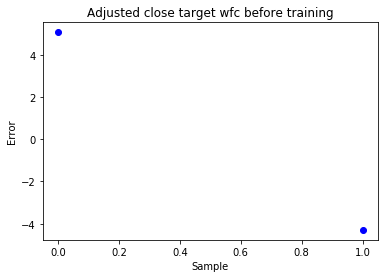

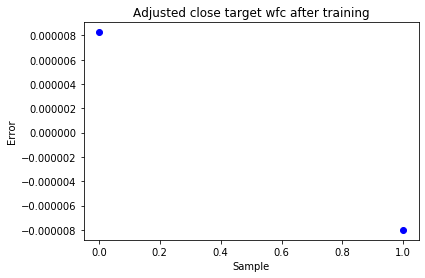


Plotting Each Sample's Time Series


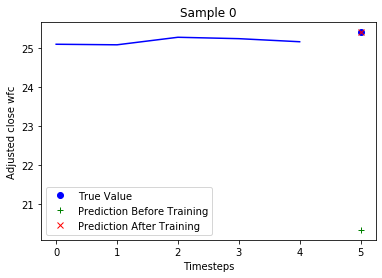

True Target Value: 25.3963
Predicted Target Value Before Training: 20.33243179321289
Predicted Target Value After Training: 25.396291732788086




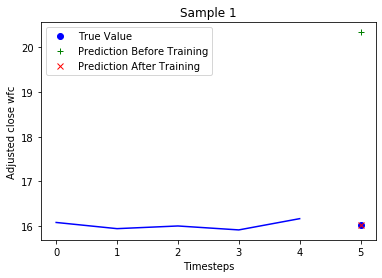

True Target Value: 16.0382
Predicted Target Value Before Training: 20.332355499267578
Predicted Target Value After Training: 16.0382080078125




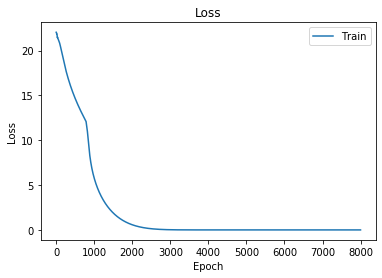

In [5]:
X_small, y_small = sample_dataset(train_dataset, sample_size=2, seed=seed)

del y_small['adjusted_close_target_JPM']
del y_small['adjusted_close_target_BAC']
del y_small['adjusted_close_target_C']

overfit_small_sample(model_notext, batch_size=6, epochs=8000, X_small=X_small, y_small=y_small, verbose=1)

From the above plots its clear that our model has overfit on our small sample of the dataset which is the desired behavior.

***

## Evaluating Model:

In this final section we train and evaluate our model architecture using a few different sets of hyperparameters. The metrics we will use to evaluate our model are mean squared error, and accuracy at predict daily stock trends.

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = None

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_dataset.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history[metric], label='Train')
    if 'val_' + metric in history:
        ax.plot(history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

def plot_print_complete_metrics(model_name, model_version, run_number, metrics_train, metrics_val, metrics_names):
    csvlog = os.path.join('logs', 'models', model_name, '_'.join(['version', str(model_version)]), 'runs', str(run_number), 'history.log')
    df = pd.read_csv(csvlog).drop_duplicates(subset='epoch', keep='last').set_index('epoch')
    plot_print_metrics(df, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=metrics_names)
    return None

Defining model.

In [3]:
import tensorflow as tf

def model_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(lstm_layer_units)(features) # with less capacity, 16 units, able to gain val loss of 1.51-50ish and see that val loss decreases model definitely is prone to overfitting
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, 
                                         name='adjusted_close_target_WFC')
    
    outputs = {
               'adjusted_close_target_WFC': output_layer(lstm)
              }
    
    model = tf.keras.Model(inputs, outputs, name='model_notext')
    
    return model

Inspecting both our training and validation datasets.

In [4]:
X_train, y_train = train_dataset
X_val, y_val = val_dataset

print('Feature names and shapes for Training Data:')
for key in X_train:
    print('{}: {}'.format(key, X_train[key].shape[1:]))
print()
print('Feature names and shapes for Validation Data:')
for key in X_val:
    print('{}: {}'.format(key, X_val[key].shape[1:]))
print()
print('Train set size: {}'.format(len(y_train['adjusted_close_target_WFC'])))
print('Validation set size: {}'.format(len(y_val['adjusted_close_target_WFC'])))

Feature names and shapes for Training Data:
adjusted_close_WFC: (5,)
8-k_WFC: (1562,)
adjusted_close_JPM: (5,)
8-k_JPM: (90363,)
adjusted_close_BAC: (5,)
8-k_BAC: (15826,)
adjusted_close_C: (5,)
8-k_C: (53958,)

Feature names and shapes for Validation Data:
adjusted_close_WFC: (5,)
8-k_WFC: (1364,)
adjusted_close_JPM: (5,)
8-k_JPM: (1706,)
adjusted_close_BAC: (5,)
8-k_BAC: (2026,)
adjusted_close_C: (5,)
8-k_C: (2636,)

Train set size: 3014
Validation set size: 1001


Defining model's hyperparameters.

In [5]:
import tensorflow as tf

# Defining Hyperparameters
output_bias_init = {key: y_train[key].mean() for key in y_train}
model_params = {
                'output_bias_init': output_bias_init, 
                'lstm_layer_units': 32
               }
training_params = {
                   'batch_size': 6, 
                   'epochs': 29
                  }
loss = tf.keras.losses.MeanSquaredError
optimizer = tf.keras.optimizers.Adam
optimizer_params = {}

model_version = 6
hyperparameters = {
                   'model_parameters': model_params,
                   'training_parameters': training_params,
                   'loss': loss, 
                   'optimizer': optimizer, 
                   'optimizer_parameters': optimizer_params, 
                   'version': model_version
                  }

# Defining Metrics
metrics = []

# Setting unique Run Number 
run_number = 0

Training model.

In [6]:
from stockanalysis.train import train

model, model_history = train(model_notext, hyperparameters, metrics, run_number, X_train, y_train, (X_val, y_val), True, True, True)

Saved hyperparameters to file: logs/models/model_notext/version_6
Train on 3014 samples, validate on 1001 samples
Epoch 1/29
2898/3014 [===========================>..] - ETA: 0s - loss: 14.6180
Epoch 00001: saving model to logs/models/model_notext/version_6/runs/0/checkpoints/cp-1.ckpt
3014/3014 [==============================] - 3s 1ms/sample - loss: 14.4193 - val_loss: 283.8424
Epoch 2/29
2982/3014 [============================>.] - ETA: 0s - loss: 6.9764
Epoch 00002: saving model to logs/models/model_notext/version_6/runs/0/checkpoints/cp-2.ckpt
3014/3014 [==============================] - 2s 501us/sample - loss: 6.9511 - val_loss: 237.4472
Epoch 3/29
2982/3014 [============================>.] - ETA: 0s - loss: 3.3400
Epoch 00003: saving model to logs/models/model_notext/version_6/runs/0/checkpoints/cp-3.ckpt
3014/3014 [==============================] - 2s 504us/sample - loss: 3.3252 - val_loss: 202.7359
Epoch 4/29
2958/3014 [============================>.] - ETA: 0s - loss: 1.8504


Evaluating model.

In [7]:
# Gathering Data

import numpy as np

metrics_train = model.evaluate(X_train, y_train, batch_size=training_params['batch_size'], verbose=0)
metrics_val = model.evaluate(X_val, y_val, batch_size=training_params['batch_size'], verbose=0)
m_preds_train = model.predict(X_train, batch_size=training_params['batch_size'])
m_preds_val = model.predict(X_val, batch_size=training_params['batch_size'])
m_preds_up_train = ((m_preds_train[1:, 0] - y_train['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
m_preds_up_val = ((m_preds_val[1:, 0] - y_val['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
labels_up_train = ((y_train['adjusted_close_target_WFC'][1:] - y_train['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
labels_up_val = ((y_val['adjusted_close_target_WFC'][1:] - y_val['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_val = np.mean(np.equal(m_preds_up_val, labels_up_val))

Learning Curves for Metrics:


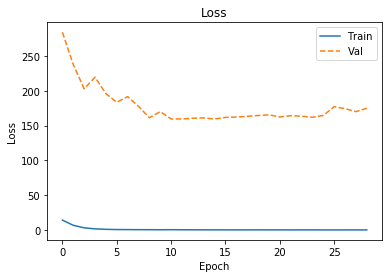

Loss on train dataset: 0.31578833328568645
Loss on validation dataset: 174.7955172659753

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.9734483903086625
Accuracy on validation dataset: 0.63


In [8]:
# Reporting Data

print('Learning Curves for Metrics:')
plot_print_metrics(model_history.history, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=model.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_val))

Complete Learning Curves for Metrics: 


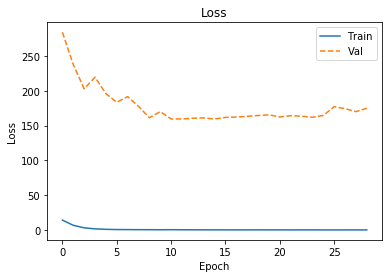

Loss on train dataset: 0.31578833328568645
Loss on validation dataset: 174.7955172659753


In [9]:
print('Complete Learning Curves for Metrics: ')
plot_print_complete_metrics('model_notext', model_version, run_number, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=model.metrics_names)

The sets of hyperparameters we tested were: $(lstm \: layer \: units=32, epochs=50)$, $(lstm \: layer \: units=64, epochs=50)$, $(lstm \: layer \: units=48, epochs=50)$, $(lstm \: layer \: units=40, epochs=50)$, $(lstm \: layer \: units=40, epochs=33)$, $(lstm \: layer \: units=32, epochs=35)$, $(lstm \: layer \: units=32, epochs=29)$ where each set of hyperparameters is in the order of the model_version number. Out of this set of experiments, the set of hyperparameters that performed the best on the validation dataset was: $(lstm \: layer \: units=40, epochs=50)$ with a mean squared error estimate of: $130.883$ and a daily trend accuracy estimate of: $74.6\%$. Screenshots of the learning curves, and metrics, along with the model checkpoints and hyperparameters can be found in the folders of the corresponding experiment given by model version number.

***